# Netflix Movies and TV Shows Data Analysis

### Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
# Load the data
data = pd.read_csv('data/netflix_titles.csv')
data.head()

## Data Cleaning

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [9]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [10]:
data.dropna(inplace=True)

In [18]:
#data['listed_in'] = data['listed_in'].apply(lambda x: x.split(', '))

# Explode the list into separate rows
data_exploded = data.explode('listed_in')

data_exploded.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,Dramas,"On a photo shoot in Ghana, an American model s..."
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,Independent Movies,"On a photo shoot in Ghana, an American model s..."
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,International Movies,"On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,British TV Shows,A talented batch of amateur bakers face off in...
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,Reality TV,A talented batch of amateur bakers face off in...


## Text Processing on Description

- Action
- Comedy
- Drama
- Fantasy
- Horror
- Mystery
- Romance
- Thriller
- Western

In [19]:
import nltk
from nltk.tokenize import word_tokenize

# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Tokenization function
def tokenize_text(text):
    return word_tokenize(text)

# Assuming `data` is a pandas DataFrame
mined_data = {'title': [], 'Tokens': [], 'listed_in': [], 'country': [], 'type': [], 'rating': []}

# Iterating over the DataFrame
for index, row in data_exploded.iterrows():
    # Tokenize the description
    words = tokenize_text(row['description'])
    
    # lowercase 
    words = [word.lower() for word in words]
    
    # Stopword removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # remove punctuation
    import re
    words = [re.sub(r'\W+', '', word) for word in words if word.isalpha()]
    
    # lemmentize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # one, two, three, four, five, six, seven, eight, nine, ten removed
    words = [word for word in words if word not in ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']]
    
    # modal verbs removed
    words = [word for word in words if word not in ['can', 'could', 'may', 'might', 'must', 'will', 'would', 'shall', 'should', 'take', 'find','help', 'get']]
    
    # Update the 'data' dataframe with the tokenized description
    mined_data['title'].append(row['title'])
    mined_data['Tokens'].append(words)
    mined_data['listed_in'].append(row['listed_in'])
    mined_data['country'].append(row['country'])
    mined_data['type'].append(row['type'])
    mined_data['rating'].append(row['rating'])
    

# Create a new DataFrame with the tokenized description
df = pd.DataFrame(mined_data)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahshid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mahshid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mahshid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,Tokens,listed_in,country,type,rating
0,Sankofa,"[photo, shoot, ghana, american, model, slip, b...",Dramas,"United States, Ghana, Burkina Faso, United Kin...",Movie,TV-MA
1,Sankofa,"[photo, shoot, ghana, american, model, slip, b...",Independent Movies,"United States, Ghana, Burkina Faso, United Kin...",Movie,TV-MA
2,Sankofa,"[photo, shoot, ghana, american, model, slip, b...",International Movies,"United States, Ghana, Burkina Faso, United Kin...",Movie,TV-MA
3,The Great British Baking Show,"[talented, batch, amateur, baker, face, compet...",British TV Shows,United Kingdom,TV Show,TV-14
4,The Great British Baking Show,"[talented, batch, amateur, baker, face, compet...",Reality TV,United Kingdom,TV Show,TV-14


### df should be used for further analysis and visualization
### data_exploded should be used for prediction

In [37]:
# Drop 'International Movies' and 'International TV Shows' as they are not specific genre
df = df[df['listed_in'] != 'International Movies']
df = df[df['listed_in'] != 'International TV Shows']
df  = df[df['listed_in'] != 'Independent Movies']


In [38]:
# add 'TV Dramas' to 'Dramas'
df['listed_in'] = df['listed_in'].replace({'TV Dramas': 'Dramas',
                                           'Action & Adventure': 'Action',
                                           'Romantic Movies': 'Romantics',
                                           'Children & Family Movies': 'Family',
                                           'Classic Movies': 'Classic',
                                           'Horror Movies': 'Horror',
                                           'Music & Musicals': 'Musical',
                                           'Sci-Fi & Fantasy': 'Fantasy',
                                           'Sports Movies': 'Sports',
                                           'LGBTQ Movies': 'LGBTQ',
                                           'Cult Movies': 'Classic',
                                           'Faith & Spirituality': 'Faith',
                                           'Anime Features': 'Anime',
                                           'TV Comedies': 'Comedies',
                                           'TV Mysteries': 'Mystery',
                                           'TV Sci-Fi & Fantasy': 'Fantasy',
                                           'TV Thrillers': 'Thrillers',
                                           'TV Horror': 'Horror',
                                           'TV Action & Adventure': 'Action',
                                           'Reality TV': 'Reality',
                                           'Teen TV Shows': 'Teen',
                                           'Classic & Cult TV': 'Classic',
                                           'Science & Nature TV': 'Science',
                                           'Crime TV Shows': 'Crime',
                                           'Romantic TV Shows': 'Romantics',
                                           'British TV Shows': 'British',
                                           'Korean TV Shows': 'Korean',
                                           'Spanish-Language TV Shows': 'Spanish',
                                           "Kids' TV": 'Family',
                                           'Stand-Up Comedy & Talk Shows': 'Stand-Up Comedy',
                                           'Anime Series': 'Anime',
                                           'Science': 'Docuseries',
                                           })


In [40]:
df["listed_in"].value_counts()

listed_in
Dramas             2345
Comedies           1583
Action              819
Romantics           600
Thrillers           550
Family              516
Documentaries       391
Horror              343
Stand-Up Comedy     305
Musical             292
Fantasy             240
Classic             180
Sports              156
LGBTQ                80
Anime                71
Faith                58
Crime                38
British              21
Movies               20
Docuseries           14
Spanish              10
Korean               10
Mystery               8
TV Shows              5
Reality               3
Teen                  3
Science               1
Name: count, dtype: int64

### Word Frequency

In [41]:
# frequency of words in each genre
def word_genre_freq(dataframe):
    genre_word_frequency = {}
    for index, row in dataframe.iterrows():
        genre = row['listed_in']
        tokens = row['Tokens']
        if genre not in genre_word_frequency:
            genre_word_frequency[genre] = Counter()
        genre_word_frequency[genre].update(tokens)    
    return genre_word_frequency

In [42]:
genre_word_freq = word_genre_freq(df)

In [45]:
genre_word_freq["Action"].most_common(10)

[('young', 71),
 ('man', 63),
 ('life', 60),
 ('agent', 55),
 ('team', 53),
 ('mission', 48),
 ('cop', 48),
 ('group', 45),
 ('new', 44),
 ('world', 43)]

### Word Cloud Visualization

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# with the top 20 words in each genre

def plot_word_cloud(genre_word_freq, genres=None):  
    for genre, freq in genre_word_freq.items():
        if genre == genres:
            freq = dict(freq.most_common(20))
            wordcloud = WordCloud(width = 800, height = 800, 
                            background_color ='white', 
                            stopwords = set(stopwords.words('english'), ),
                            min_font_size = 10).generate_from_frequencies(freq)
    
            plt.figure(figsize = (8, 8), facecolor = None) 
            plt.imshow(wordcloud) 
            plt.axis("off") 
            plt.tight_layout(pad = 0) 
            plt.title(genre)
            plt.show()

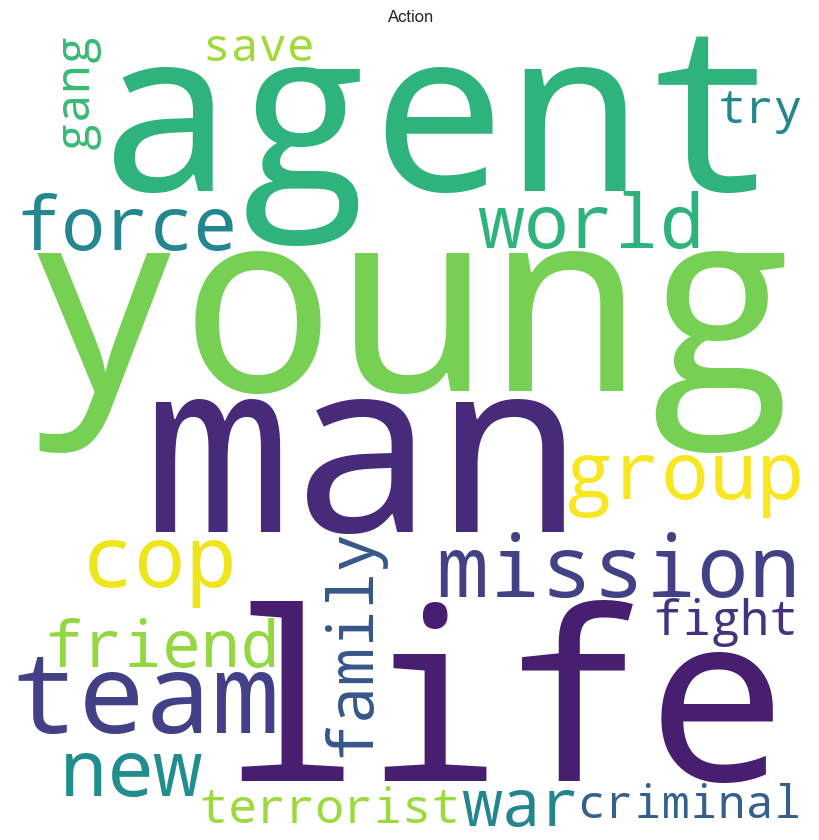

In [74]:
plot_word_cloud(genre_word_freq, genres='Action')

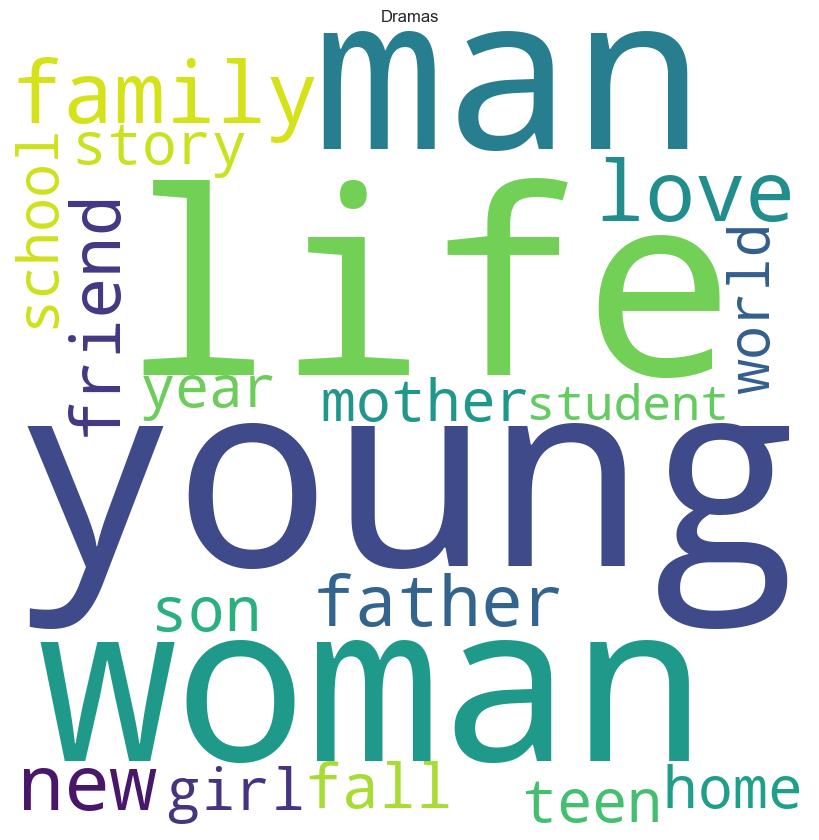

In [75]:
plot_word_cloud(genre_word_freq, genres='Dramas')

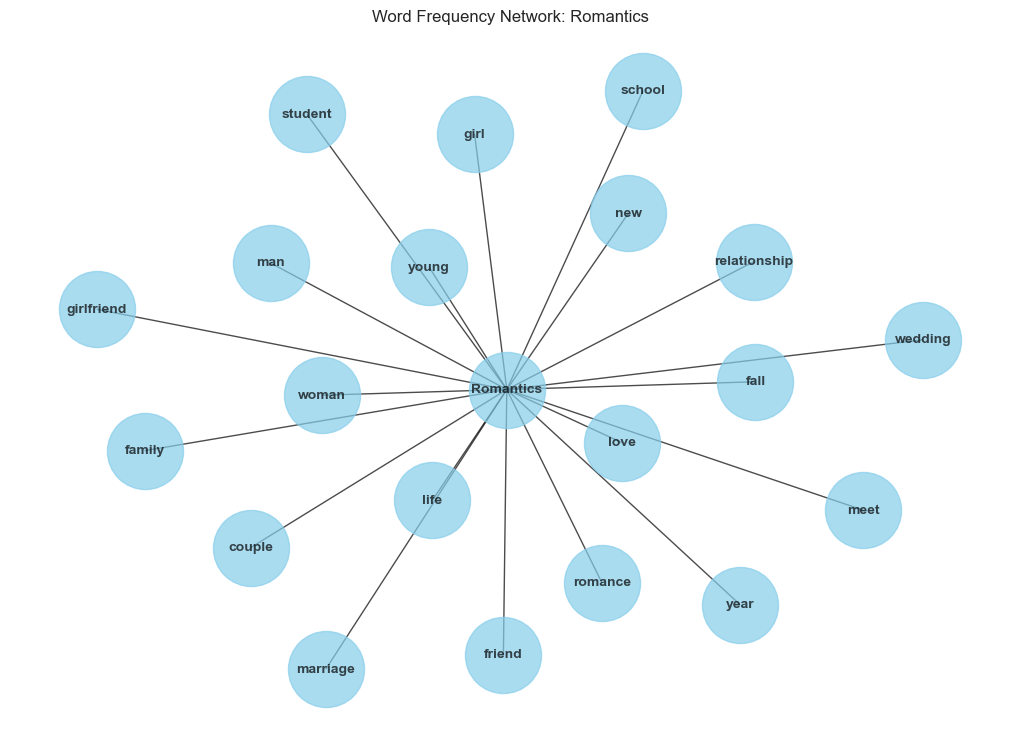

In [110]:
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
def create_network_graph(genre_word_freq, genres=None):
    G = nx.Graph()
    for genre, freq in genre_word_freq.items():
        if genre == genres:
            freq = dict(freq.most_common(20))
            if genre not in G:
                G.add_node(genre)
                for word, count in freq.items():
                    if word not in G:
                        G.add_node(word)
                    G.add_edge(genre, word, weight=count)
                    
    return G
genre = 'Romantics'
g = create_network_graph(genre_word_freq, genres=genre)

pos_centered = nx.spring_layout(g, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(g, pos_centered, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='black', width=1, alpha=0.7)
plt.title(f"Word Frequency Network: " + genre)
plt.show()
                    

### Shared Term 

In [48]:
# Visualize the shared most frequent words between genres
def shared_terms(genre_word_freq):
    shared_terms = {}
    for genre, freq in genre_word_freq.items():
        shared_terms[genre] = {}
        for genre2, freq2 in genre_word_freq.items():
            if genre != genre2:
                shared_terms[genre][genre2] = set(freq).intersection(set(freq2))
    return shared_terms

In [55]:
shared_term = shared_terms(genre_word_freq)

In [56]:
shared_term['Action']['Dramas']

{'bank',
 'discover',
 'racer',
 'tracking',
 'tv',
 'grand',
 'loved',
 'complicate',
 'willing',
 'dance',
 'come',
 'kill',
 'hundred',
 'inmate',
 'experiment',
 'connection',
 'style',
 'romance',
 'carter',
 'guest',
 'much',
 'blame',
 'peaceful',
 'incredible',
 'path',
 'operative',
 'assignment',
 'enforcer',
 'sadistic',
 'tow',
 'antique',
 'wildlife',
 'israel',
 'reunited',
 'warehouse',
 'city',
 'entertains',
 'suicidal',
 'bird',
 'vault',
 'mumbai',
 'place',
 'ravaged',
 'track',
 'saint',
 'organization',
 'colombian',
 'sam',
 'die',
 'money',
 'made',
 'foreign',
 'personal',
 'showdown',
 'hinders',
 'bullet',
 'artist',
 'practice',
 'analyst',
 'us',
 'commissioner',
 'village',
 'opposition',
 'coast',
 'dystopian',
 'crossfire',
 'shocking',
 'sarah',
 'rock',
 'charles',
 'catastrophic',
 'tricky',
 'accident',
 'allied',
 'strives',
 'honorable',
 'tapped',
 'volatile',
 'revealed',
 'pampered',
 'market',
 'bloodthirsty',
 'usher',
 'musical',
 'asia',
 'e

In [62]:
# visualized shared words between genres as a network graph
def plot_shared_terms(shared_terms, genre1=None, genre2=None):
    G = nx.Graph()
    for genre, shared in shared_terms.items():
        if genre == genre1:
            for genre2, words in shared.items():
                for word in words:
                    if word not in G:
                        G.add_node(word)
                    G.add_edge(genre, word, weight=1)
                    G.add_edge(genre2, word, weight=1)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='black', width=1, alpha=0.7)
    plt.title(f"Shared Words Network: " + genre1 + ' and ' + genre2)
    plt.show()

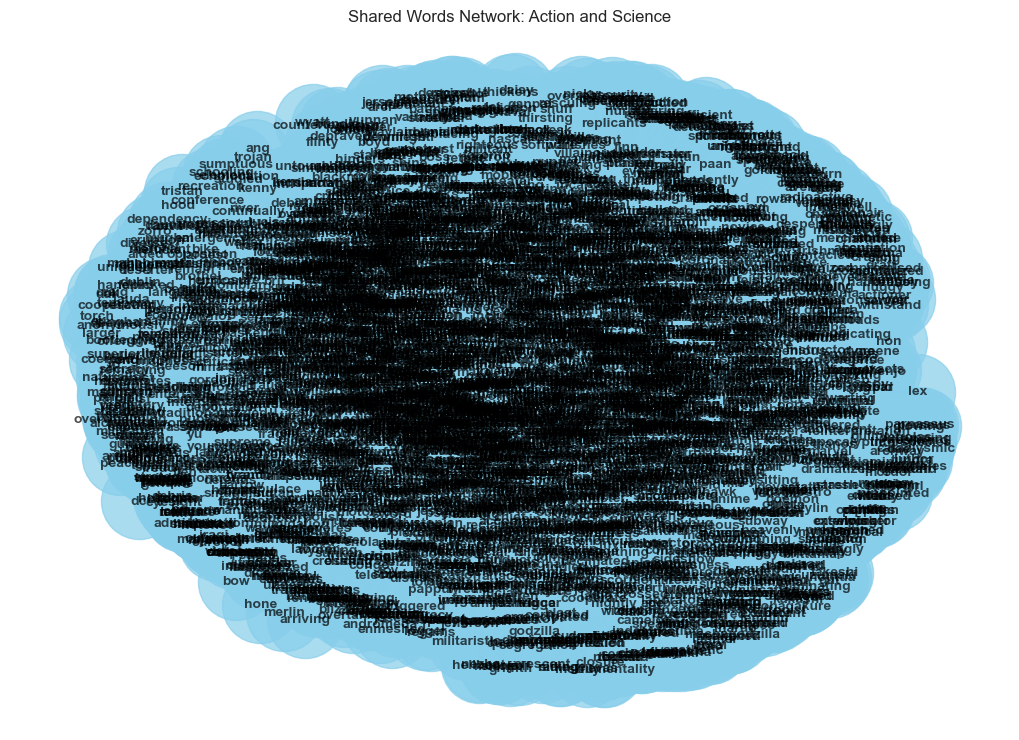

In [64]:
plot_shared_terms(shared_term, genre1='Action', genre2='Dramas')

### Language Modeling and genre prediction

```{python}

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

data_desc = data_desc.reset_index(drop=True)

# Optionally, remove duplicate rows if necessary
data_desc = data_desc.drop_duplicates()
data_desc['combined_features'] = data_desc['description'] + ' ' + data_desc['country'].fillna('') + ' ' + data_desc['rating'].fillna('')

# Set X and y using the exploded DataFrame
X = data_desc['combined_features']
y = data_desc['listed_in']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Encode the target variable (genres)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a pipeline with TF-IDF and RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)),  # Use bigrams and trigrams
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))  # Multinomial Naive Bayes
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
'''

Accuracy: 0.22